In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!git clone https://github.com/kamilabielska/gans

In [3]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as layers

from tensorflow.keras import Sequential, Model
from tensorflow.keras.preprocessing import image_dataset_from_directory

from gans.gans.models import GAN, ProGAN
from gans.gans.layers import GaussianNoiseAnnealing, WeightedAdd, PixelNorm, MinibatchSTD
from gans.gans.callbacks import SaveGeneratedImages, GaussianSTDAnnealing

from gans.utils.vizualization import plot_sample_images, plot_history, gif_from_image_folder

sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.25)


# get anime data

In [4]:
!cp -r 'drive/My Drive/anime.zip' .

In [5]:
!unzip -q anime.zip
!rm anime.zip

In [6]:
size = 96
batch_size = 128
folder_name = 'images'

# prepare data

In [7]:
n_channels = 3
conditional = False

In [8]:
color_mode = {
    1: 'grayscale',
    3: 'rgb'
}
label_mode = None if not conditional else 'categorical'

In [9]:
dataset_kwargs = dict(
    label_mode=label_mode,
    batch_size=batch_size,
    image_size=(size, size),
    color_mode=color_mode[n_channels],
    crop_to_aspect_ratio=True,
    shuffle=True,
    seed=42
)

In [10]:
train_data = image_dataset_from_directory(folder_name, **dataset_kwargs)

Found 63565 files belonging to 1 classes.


In [11]:
rescaling_layer = layers.Rescaling(scale=1./127.5, offset=-1.)
rescale = rescaling_layer if not conditional else lambda x, y: (rescaling_layer(x), y)
train_data = train_data.map(rescale)

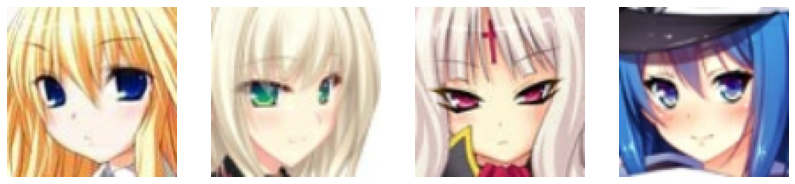

In [12]:
plot_sample_images(train_data if not conditional else train_data.map(lambda x, y: x), rescaled=True)

# deep convolutional GAN

In [21]:
latent_dim = 128
classes = [] if not conditional else train_data.class_names
gen_input_dim = latent_dim + len(classes)

alpha = 0.2
conv_kwargs = dict(
    kernel_size=3,
    strides=1,
    padding='same',
    kernel_initializer='he_normal',
    use_bias=False
)

In [22]:
init_size = size // 2**3

In [23]:
def conv_block(n_filters, alpha=0.2, **kwargs):
    block = Sequential([
        layers.Conv2D(filters=n_filters, **kwargs),
        layers.LeakyReLU(alpha),
        layers.BatchNormalization(),
    ])
    return block

In [24]:
generator = Sequential([
    layers.Input(shape=[gen_input_dim]),
    layers.Dense(units=init_size * init_size * 256),
    layers.LeakyReLU(alpha),

    layers.Reshape([init_size, init_size, 256]),

    conv_block(256, alpha=alpha, **conv_kwargs),
    conv_block(256, alpha=alpha, **conv_kwargs),
    layers.UpSampling2D(),
    GaussianNoiseAnnealing(0.1),
    
    conv_block(128, alpha=alpha, **conv_kwargs),
    layers.UpSampling2D(),
    GaussianNoiseAnnealing(0.1),

    conv_block(64, alpha=alpha, **conv_kwargs),
    layers.UpSampling2D(),
    GaussianNoiseAnnealing(0.1),

    layers.Conv2D(
        filters=n_channels, kernel_size=3,
        padding='same', activation='tanh')
])

In [25]:
discriminator = Sequential([
    layers.Input(shape=[size, size, n_channels + len(classes)]),
    GaussianNoiseAnnealing(0.1),

    conv_block(32, alpha=alpha, **conv_kwargs),
    layers.AveragePooling2D(),
    layers.Dropout(0.3),

    conv_block(64, alpha=alpha, **conv_kwargs),
    layers.AveragePooling2D(),
    
    conv_block(128, alpha=alpha, **conv_kwargs),
    layers.AveragePooling2D(),
    MinibatchSTD(),

    conv_block(256, alpha=alpha, **conv_kwargs),
    conv_block(256, alpha=alpha, **conv_kwargs),
    layers.AveragePooling2D(),
    layers.Dropout(0.5),

    layers.GlobalMaxPooling2D(),
    layers.Dense(units=1)
])

In [26]:
noise = tf.random.normal([4, latent_dim])
callbacks = [
    SaveGeneratedImages(data=noise, path='drive/MyDrive/anime_progress'),
    SaveGeneratedImages(n=4, path='drive/MyDrive/anime_random'),
    GaussianSTDAnnealing(0.00001)
]

loss = 'bce'

opt_params = {
    'bce': {
        'learning_rate': 2e-4,
        'beta_1': 0.5
    },
    'wgan_gp': {
        'learning_rate': 1e-4,
        'beta_1': 0,
        'beta_2': 0.9
    }
}

In [27]:
gan = GAN(generator, discriminator, classes=classes, gp_weight=0)
gan.compile(
    gen_optimizer=tf.keras.optimizers.Adam(**opt_params[loss]),
    disc_optimizer=tf.keras.optimizers.Adam(**opt_params[loss]),
    loss_type=loss,
    label_smoothing=True
)

In [28]:
fit = gan.fit(train_data, epochs=80, callbacks=callbacks)

Epoch 1/80
  6/497 [..............................] - ETA: 3:03 - gen_loss: 1.6686 - disc_loss: 1.1372

497/497 [==============================] - 192s 371ms/step - gen_loss: 2.7356 - disc_loss: 0.8093
Epoch 2/80
497/497 [==============================] - 184s 369ms/step - gen_loss: 2.1886 - disc_loss: 0.8718
Epoch 3/80
497/497 [==============================] - 184s 370ms/step - gen_loss: 2.2450 - disc_loss: 0.8385
Epoch 4/80
497/497 [==============================] - 184s 368ms/step - gen_loss: 2.1401 - disc_loss: 0.8702
Epoch 5/80
497/497 [==============================] - 185s 371ms/step - gen_loss: 2.0097 - disc_loss: 0.9145
Epoch 6/80
497/497 [==============================] - 184s 370ms/step - gen_loss: 1.8330 - disc_loss: 0.9627
Epoch 7/80
497/497 [==============================] - 184s 370ms/step - gen_loss: 1.7340 - disc_loss: 0.9938
Epoch 8/80
497/497 [==============================] - 184s 368ms/step - gen_loss: 1.6902 - disc_loss: 1.0070
Epoch 9/80
497/497 [==============================] - 184s 369ms/step - gen_loss: 1.6457 - disc_loss: 1.0182
Epoch 10/80
497/497 [=========

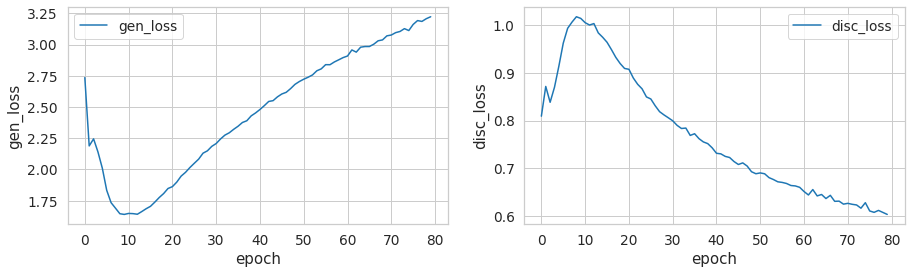

In [29]:
plot_history(fit, ['gen_loss', 'disc_loss'], val=False)

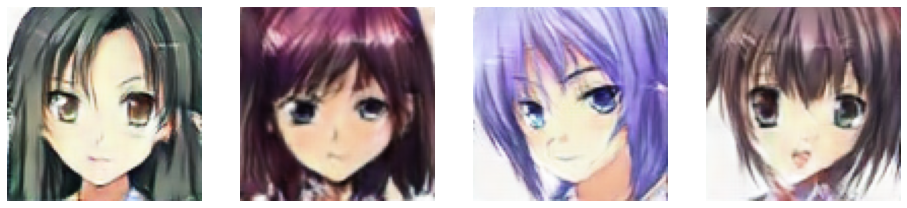

In [44]:
gan.generate_new_samples(n=4)

In [45]:
gif_from_image_folder('drive/My Drive/anime_progress', 'drive/MyDrive/gan_progress.gif')

# progressive growing of GANs

In [ ]:
def building_block(n_filters, alpha=0.2, pixel_norm=False, **kwargs):
    name = fr'conv_block_{n_filters[0]}_{n_filters[1]}'
    norm_layer = PixelNorm if pixel_norm else layers.BatchNormalization
    block = Sequential([
        layers.Conv2D(filters=n_filters[0], **kwargs),
        layers.LeakyReLU(alpha),
        norm_layer(),
        layers.Conv2D(filters=n_filters[1], **kwargs),
        layers.LeakyReLU(alpha),
        norm_layer(),
    ], name=name)
    return block

def gen_output_layer(name=None):
    return layers.Conv2D(
        filters=n_channels, kernel_size=1, padding='same',
        name=name)

def disc_input_layer(n_filters, alpha=0.2, name=None):
    return Sequential([
        layers.Conv2D(filters=n_filters, kernel_size=1, padding='same'),
        layers.LeakyReLU(alpha)
    ], name=name)

In [ ]:
latent_dim = 128
classes = [] if not conditional else train_data.class_names
gen_input_dim = latent_dim + len(classes)

alpha = 0.2
conv_kwargs = dict(
    kernel_size=3,
    padding='same',
    kernel_initializer='he_normal'
)

In [ ]:
init_size = size // 2**4
init_n_filters = 256

In [ ]:
input_layer = layers.Input(shape=[gen_input_dim])
g = layers.Dense(units=init_size * init_size * init_n_filters)(input_layer)
g = layers.LeakyReLU(alpha)(g)
g = layers.Reshape([init_size, init_size, init_n_filters])(g)

g = layers.Conv2D(filters=init_n_filters, kernel_size=4, padding='same')(g)
g = layers.LeakyReLU(alpha)(g)
g = layers.BatchNormalization()(g)
g = layers.Conv2D(filters=init_n_filters, kernel_size=3, padding='same')(g)
g = layers.LeakyReLU(alpha)(g)
g = layers.BatchNormalization()(g)

output = gen_output_layer(name='to_rgb')(g)
output = layers.Activation(tf.keras.activations.tanh, name='to_skip_tanh')(output)

generator = tf.keras.Model(inputs=input_layer, outputs=output)

In [ ]:
input_layer = layers.Input(shape=[init_size, init_size, n_channels+len(classes)], name='to_skip_input')
d = disc_input_layer(init_n_filters, name='from_rgb')(input_layer)

d = MinibatchSTD()(d)
d = layers.Conv2D(filters=init_n_filters, kernel_size=3, padding='same')(d)
d = layers.LeakyReLU(alpha)(d)
d = layers.BatchNormalization()(d)
d = layers.Conv2D(filters=init_n_filters, kernel_size=4, padding='same')(d)
d = layers.LeakyReLU(alpha)(d)
d = layers.BatchNormalization()(d)
d = layers.Dropout(0.3)(d)

d = layers.GlobalMaxPooling2D()(d)
output = layers.Dense(units=1)(d)

discriminator = tf.keras.Model(inputs=input_layer, outputs=output)

In [ ]:
loss = 'bce'

opt_params = {
    'bce': {
        'learning_rate': 2e-4,
        'beta_1': 0.5
    },
    'wgan_gp': {
        'learning_rate': 5e-4,
        'beta_1': 0,
        'beta_2': 0.99,
        'epsilon': 1e-08
    }
}

In [ ]:
progan = ProGAN(
    generator=generator, discriminator=discriminator,
    classes=classes, gp_weight=0
)
progan.compile(
    gen_optimizer=tf.keras.optimizers.Adam(**opt_params[loss]),
    disc_optimizer=tf.keras.optimizers.Adam(**opt_params[loss]),
    loss_type=loss,
    label_smoothing=True,
    building_block=building_block,
    block_kwargs=conv_kwargs,
    gen_output_layer=gen_output_layer,
    disc_input_layer=disc_input_layer,
    init_n_filters=init_n_filters,
    drift=0
)

In [ ]:
gen_images_path = 'drive/MyDrive/anime_pgg'
model_graph_path = 'drive/MyDrive/gan_growing'

In [ ]:
progan.train(train_data, 100, 5, gen_images_path, model_graph_path=model_graph_path)

Epoch 1 / 100


100%|██████████| 487/487 [02:48<00:00,  2.88it/s]


generator loss: 2.7564,  discriminator loss: 0.7968

Epoch 2 / 100


100%|██████████| 487/487 [03:21<00:00,  2.41it/s]


generator loss: 1.4894,  discriminator loss: 1.0594

Epoch 3 / 100


100%|██████████| 487/487 [03:21<00:00,  2.41it/s]


generator loss: 1.2075,  discriminator loss: 1.1845

Epoch 4 / 100


100%|██████████| 487/487 [02:41<00:00,  3.01it/s]


generator loss: 1.1492,  discriminator loss: 1.2043

Epoch 5 / 100
fade in mode activated


100%|██████████| 487/487 [02:56<00:00,  2.76it/s]


generator loss: 1.5133,  discriminator loss: 1.0558

Epoch 6 / 100


100%|██████████| 487/487 [02:56<00:00,  2.75it/s]


generator loss: 1.9869,  discriminator loss: 0.8540

Epoch 7 / 100


100%|██████████| 487/487 [03:21<00:00,  2.41it/s]


generator loss: 1.9689,  discriminator loss: 0.8650

Epoch 8 / 100


100%|██████████| 487/487 [03:06<00:00,  2.61it/s]


generator loss: 2.5106,  discriminator loss: 0.7380

Epoch 9 / 100


100%|██████████| 487/487 [03:01<00:00,  2.69it/s]


generator loss: 2.5616,  discriminator loss: 0.7383

Epoch 10 / 100
stabilizing mode activated


100%|██████████| 487/487 [03:21<00:00,  2.41it/s]


generator loss: 2.8471,  discriminator loss: 0.6826

Epoch 11 / 100


100%|██████████| 487/487 [02:57<00:00,  2.74it/s]


generator loss: 3.2866,  discriminator loss: 0.5842

Epoch 12 / 100


100%|██████████| 487/487 [03:21<00:00,  2.41it/s]


generator loss: 3.2445,  discriminator loss: 0.5910

Epoch 13 / 100


100%|██████████| 487/487 [03:21<00:00,  2.41it/s]


generator loss: 2.6124,  discriminator loss: 0.7131

Epoch 14 / 100


100%|██████████| 487/487 [03:21<00:00,  2.41it/s]


generator loss: 2.5666,  discriminator loss: 0.7088

Epoch 15 / 100
fade in mode activated


100%|██████████| 487/487 [03:21<00:00,  2.41it/s]


generator loss: 3.2901,  discriminator loss: 0.6192

Epoch 16 / 100


100%|██████████| 487/487 [03:21<00:00,  2.41it/s]


generator loss: 2.3505,  discriminator loss: 0.8366

Epoch 17 / 100


100%|██████████| 487/487 [03:15<00:00,  2.49it/s]


generator loss: 1.7919,  discriminator loss: 0.9535

Epoch 18 / 100


100%|██████████| 487/487 [03:16<00:00,  2.48it/s]


generator loss: 1.8331,  discriminator loss: 0.9138

Epoch 19 / 100


100%|██████████| 487/487 [03:15<00:00,  2.49it/s]


generator loss: 1.9373,  discriminator loss: 0.9007

Epoch 20 / 100
stabilizing mode activated


100%|██████████| 487/487 [03:16<00:00,  2.48it/s]


generator loss: 1.9956,  discriminator loss: 0.8733

Epoch 21 / 100


100%|██████████| 487/487 [03:14<00:00,  2.50it/s]


generator loss: 2.0267,  discriminator loss: 0.8691

Epoch 22 / 100


100%|██████████| 487/487 [03:21<00:00,  2.41it/s]


generator loss: 1.9719,  discriminator loss: 0.8800

Epoch 23 / 100


100%|██████████| 487/487 [03:21<00:00,  2.41it/s]


generator loss: 1.9567,  discriminator loss: 0.8829

Epoch 24 / 100


100%|██████████| 487/487 [03:14<00:00,  2.50it/s]


generator loss: 2.0115,  discriminator loss: 0.8809

Epoch 25 / 100
fade in mode activated


  0%|          | 0/487 [00:20<?, ?it/s]


ResourceExhaustedError: ignored

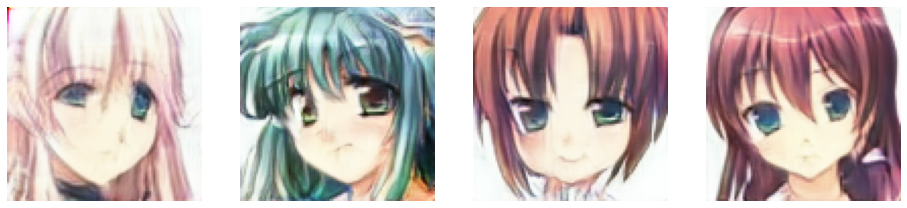

In [ ]:
progan.generate_new_samples()

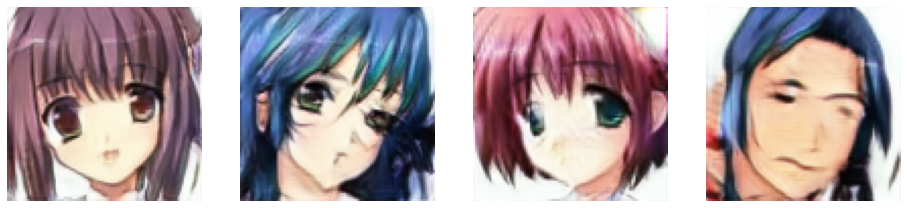

In [ ]:
progan.generate_new_samples()

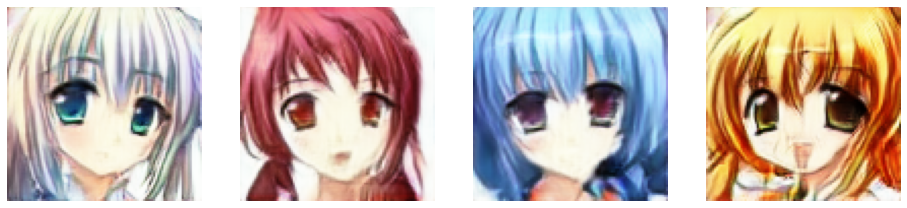

In [ ]:
progan.generate_new_samples()